In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
import shapely
import copy

In [ ]:
# symlink hydrography data to avoid downloading NHDPlus on the fly in this short course.
# If you wish to use this notebook more generally, please comment or remove this cell!
import os

try: os.mkdir('/home/jovyan/workdir/notebooks/data/hydrography/')
except FileExistsError: pass

# make sure this doesn't already exist due to a failed download
try: os.rmdir('/home/jovyan/workdir/notebooks/data/hydrography/NHDPlus_H_0601_GDB/raw')
except: pass

try: os.rmdir('/home/jovyan/workdir/notebooks/data/hydrography/NHDPlus_H_0601_GDB')
except: pass

try: os.symlink('/home/jovyan/data/hydrography/NHDPlus_H_0601_GDB',
               '/home/jovyan/workdir/notebooks/data/hydrography/NHDPlus_H_0601_GDB')
except FileExistsError: pass


In [2]:
import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.crs
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.densification
import watershed_workflow.condition

import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

crs = watershed_workflow.crs.default_crs()

# SplitHucs 

<b> Class for dealing with the multiple interacting views of HUCs </b>

In [3]:
# Just download some data... a collection of HUC 8 polygons in '0601'
source = watershed_workflow.source_list.FileManagerNHDPlus()
_, hucs = watershed_workflow.get_hucs(source, '0601', 8, crs)

2023-12-10 18:51:58,200 - root - INFO: 
2023-12-10 18:51:58,203 - root - INFO: Loading level 8 HUCs in 0601
2023-12-10 18:51:58,204 - root - INFO: ------------------------------
2023-12-10 18:51:58,213 - root - INFO: Using HUC file "/home/jovyan/workdir/notebooks/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2023-12-10 18:51:58,445 - root - INFO: ... found 16 HUCs
2023-12-10 18:51:58,447 - root - INFO:   -- 06010103
2023-12-10 18:51:58,448 - root - INFO:   -- 06010105
2023-12-10 18:51:58,448 - root - INFO:   -- 06010106
2023-12-10 18:51:58,449 - root - INFO:   -- 06010204
2023-12-10 18:51:58,449 - root - INFO:   -- 06010104
2023-12-10 18:51:58,450 - root - INFO:   -- 06010201
2023-12-10 18:51:58,450 - root - INFO:   -- 06010207
2023-12-10 18:51:58,451 - root - INFO:   -- 06010208
2023-12-10 18:51:58,452 - root - INFO:   -- 06010205
2023-12-10 18:51:58,452 - root - INFO:   -- 06010206
2023-12-10 18:51:58,453 - root - INFO:   -- 06010102
2023-12-10 18:51:58,454 - root - INFO:  

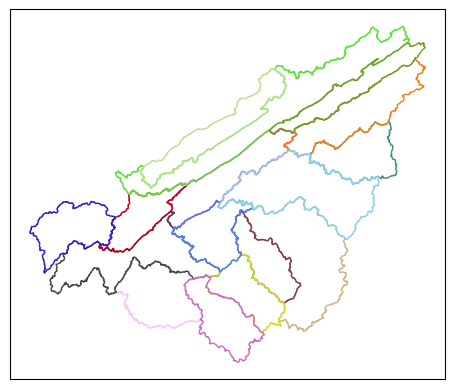

In [4]:
# plot the HUCs we got:
watershed_workflow.plot.shplys(hucs, crs)

**Key concept**

These polygons share common boundaries that (nearly exactly) coincide.  Once we start to simplify them, or to snap them to river nodes, or to otherwise turn them into something suitable for a mesh, they will not necessarily coincide.  _We need polygons that share a common boundary to be **discretely** the same._

The `SplitHUCs` object is used to ensure shared boundaries stay discretely the same through all transformations.


In [ ]:
split_hucs = watershed_workflow.split_hucs.SplitHUCs(hucs)
split_hucs

The resulting object stores segments, which may be on the exterior or interior boundary, and collections of those segments that can be combined to re-form the original polygons.

### HUC Segments

In [ ]:
# how many segments were formed?  What is a segment? (a shapely LineString)
print(len(split_hucs.segments))
split_hucs.segments[0]

In [ ]:
# plot all segments
watershed_workflow.plot.shplys(split_hucs.segments, crs)

### HUC Polygons

Reforming the polygons is straightforward by calling the API, but realize that you shouldn't keep these polygons -- let the `SplitHUCs` object manage them.

In [ ]:
# get a specific polygon
split_hucs.polygon(1)

In [ ]:
# iterate over each polygon
split_hucs.polygons() 


In [ ]:
# e.g. sum the area:
area = sum(poly.area for poly in split_hucs.polygons())
print('Total area =', area, 'm^3')

In [ ]:
# or get the interior
split_hucs.exterior()

In [ ]:
# SplitHUCs saves properties
dict(split_hucs.polygon(3).properties)

# Rivers

Watershed Workflow assumes that all rivers are dendritic, and so stores **rivers** as a tree data structure, called `River`.

### Reaches
Throughout, we will use the word **reach** to define the shapely `LineString` representing a segment of a river.


In [ ]:
# Coweeta Hydrologic Lab will be used as our test area
_, coweeta = watershed_workflow.get_shapes('../Coweeta_data/input_data/coweeta_basin.shp', out_crs=crs)
coweeta = coweeta[0]

In [ ]:
# get some data -- all reaches in Coweeta
_, reaches = watershed_workflow.get_reaches(source, '0601', coweeta, 
                                            in_crs=crs, out_crs=crs,
                                            in_network=True, properties=True)

In [ ]:
# plot the watershed and reaches
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(3,3))
watershed_workflow.plot.shply(coweeta, crs, 'k', ax)
watershed_workflow.plot.shplys(reaches, crs, None, ax)

Note that these reaches come with properties, including NHDPlus Value Added Attributes.

In [ ]:
dict(reaches[0].properties)

### Construction

Rivers are constructed using collection of reaches using one of the two methods:

1) `geometry` looks at coincident coordinates.  This is needed when working with non-NHD data.
2) `hydroseq` valid only for NHDPlus data, this uses the  NHDPlus VAA tables Hydrologic Sequence. If using this method, get_reaches() must have been called with both
  'HydrologicSequence' and 'DownstreamMainPathHydroSeq' properties requested (or properties=True).  This is the better method if working with NHD data.

In [ ]:
rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq')
river = rivers[0]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
watershed_workflow.plot.rivers(rivers, ax=ax, crs=None)
ax.set_aspect('equal', adjustable='box')


### River node

A `River` is a composed of nodes. A single node in the River is also a `River` object, representing one reach and its upstream children.

In [ ]:
river = rivers[0]
node = river

# the node's reach segment
node.segment

In [ ]:
# the node's upstream (contributing) children reaches are themselves River objects
node.children

In [ ]:
fig,ax = watershed_workflow.plot.get_ax(crs, figsize=(3,3))
watershed_workflow.plot.rivers(node.children, crs, ax=ax)
watershed_workflow.plot.shply(node.segment, crs, 'k', ax)

### Traversing Tree Structure

Basic tree traversal uses the `preOrder()` method, which is a depth-first traversal of the tree.

In [ ]:
nodes = [node for node in river.preOrder()]

We can access individial nodes and its "relatives"

In [ ]:
# access individual nodes
node = nodes[0]  ##### CHANGE TO 2, 3, .. and march up the river #####

fig, ax = plt.subplots(1, 1, figsize=(3,3))
watershed_workflow.plot.river(node, ax=ax, crs=None, color='b')
ax.set_aspect('equal', adjustable='box')

In [ ]:
# access siblings
node = nodes[1]
siblings = list(node.siblings()); print(siblings)

fig, ax = plt.subplots(1, 1, figsize=(3,3))
watershed_workflow.plot.river(node, crs, 'b', ax)
watershed_workflow.plot.rivers(siblings, crs, 'r', ax)


In [ ]:
# access parent
parent = node.parent

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
watershed_workflow.plot.river(node, crs, 'b', ax)
watershed_workflow.plot.shply(parent.segment, crs, 'r', ax)


### Editing the River

In [ ]:
reach_backup = river.segment

# move some coordinates
for i in range(50,400):
    river.moveCoordinate(i, np.array(river.segment.coords[i]) + np.array([0, 100]))

# plot
watershed_workflow.plot.shplys([river.segment, reach_backup], crs)

# revert that change!
river.segment = reach_backup

In [ ]:
river.is_continuous()